In [268]:
import argparse
import random
import sys
import yaml
from os.path import join, exists
import os
import s3fs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, power_transform
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error
import tensorflow as tf

from mlmicrophysics.metrics import heidke_skill_score, peirce_skill_score, hellinger_distance, root_mean_squared_error, r2_corr
from mlmicrophysics.models import DenseNeuralNetwork
from mlmicrophysics.data import subset_data_files_by_date, assemble_data_files
from mlmicrophysics.data import log10_transform, inverse_log10_transform
from mlmicrophysics.data import neg_log10_transform, inverse_neg_log10_transform, zero_transform 
from mlmicrophysics.data import categorize_output_values

from operator import lt, le, eq, ne, ge, gt
from copy import deepcopy

In [269]:
# define model hyper parameters
from sklearn.metrics import zero_one_loss, hamming_loss, max_error, roc_curve


In [238]:
# define data parameters

data_path = "ncar-aiml-data-commons/microphysics"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    out_path = "/content/gdrive/My Drive/micro_models/base"
else:
    out_path = "./micro_models/base/"
if not exists(out_path):
    os.makedirs(out_path)
subsample = 0.1
input_cols = ["QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in", "RHO_CLUBB_lev"]
output_cols = ["qrtend_TAU", "nctend_TAU", "nrtend_TAU"]

subset_data = {"train_date_start" : 0,
               "train_date_end" : 11000,
               "test_date_start" : 11100,
               "test_date_end" : 17500}

# set random seed
seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Set subsampling
subsample = 0.1

In [239]:
# New version of assemble that reads in data without applying scaling or transformation, so that they can be tested without 
# reloading every time
def assemble_data_files_no_transform(files, input_cols, output_cols, subsample=1,
                        meta_cols=("lat", "lon", "lev", "depth", "row", "col", "pressure", "temperature",
                                   "time", "qrtend_MG2", "nrtend_MG2", "nctend_MG2")):
    """
    This function loads data from a list of files
    Args:
        files: List of files being loaded
        input_cols: List of input columns for training the neural networks
        output_cols: List of output columns
        train: Whether to fit the Scaler objects or
        subsample:
        meta_cols:
    Returns:
    """
    all_input_data = []
    all_output_data = []
    all_meta_data = []
    for i,filename in enumerate(files):
        if i%10 == 0:
            print(f"Finished loading {i}/{len(files)} files... opening file {filename}")
        data = open_data_file(filename)
        if subsample < 1:
            sample_index = int(np.round(data.shape[0] * subsample))
            sample_indices = np.sort(np.random.permutation(np.arange(data.shape[0]))[:sample_index])
        else:
            sample_indices = np.arange(data.shape[0])
        all_input_data.append(data.loc[sample_indices, input_cols])
        all_output_data.append(data.loc[sample_indices, output_cols])
        all_meta_data.append(data.loc[sample_indices, meta_cols])
        del data
    print("Combining data")
    combined_input_data = pd.concat(all_input_data, ignore_index=True)
    combined_output_data = pd.concat(all_output_data, ignore_index=True)
    combined_meta_data = pd.concat(all_meta_data, ignore_index=True)
    print("Combined Data Size", combined_input_data.shape)
    del all_input_data[:]
    del all_output_data[:]
    
    return combined_input_data, combined_output_data, combined_meta_data

In [240]:
def categorize_output_values(output_values, output_transforms, output_scalers=None):
    """
    Transform and rescale the values of a single output variable based on specified transforms and scaling functions.
    The microphysics tendencies can be either 0 or nonzero and tend to have exponential distributions. Machine
    learning models tend to perform better when the data are more Gaussian. To account for this, we perform
    log transforms on the nonzero values and then normalize them. The rain water number concentration (Nr)
    tendencies have both positive and negative exponential tendencies, so we have separate models for each side
    and separate transformations and normalizations.
    Currently, we have support for the following transforms:
    * log10_transform: applies np.log10
    * neg_log10_transform: applies np.log10 to the additive inverse of the inputs
    * zero_transform: returns an array the same shape as the input but with all 0s
    We support the following scalers:
    * StandardScaler:
    * MinMaxScaler: Rescales values to range between 0 and 1
    * MaxAbsScaler:
    Args:
        output_values: numpy.ndarray of shape (samples, 1) with the raw output values from the microphysics
        output_transforms: dictionary with keys indicating sign of tendency and values containing a 3-element list
         [comparison operator, splitting threshold, transform type].
        output_scalers:
    Returns:
    """
    ops = {"<": lt, "<=": le, "==": eq, "!=": ne, ">=": ge, ">": gt}

    labels = np.zeros(output_values.shape, dtype=int)
    transformed_outputs = np.zeros(output_values.shape)
    scaled_outputs = np.zeros(output_values.shape)
    if output_scalers is None:
        output_scalers = {}
    for label, comparison in output_transforms.items():
        class_indices = ops[comparison[0]](output_values, float(comparison[1]))
        labels[class_indices] = label
        transformed_outputs[class_indices] = transforms[comparison[2]](output_values[class_indices],
                                                                       eps=float(comparison[1]))
        if comparison[3] != "None":
            if label not in list(output_scalers.keys()):
                output_scalers[label] = scalers[comparison[3]]()
                scaled_outputs[class_indices] = output_scalers[label].fit_transform(
                    transformed_outputs[class_indices].reshape(-1, 1)).ravel()
            else:
                scaled_outputs[class_indices] = output_scalers[label].transform(
                    transformed_outputs[class_indices].reshape(-1, 1)).ravel()
        else:
            output_scalers[label] = None
    return labels, transformed_outputs, scaled_outputs, output_scalers

In [241]:
def transform_data(combined_input_data, combined_output_data, combined_meta_data, input_cols, output_cols, input_transforms, 
                   output_transforms, input_scaler, output_scalers=None, train=True):
    print("Transforming data")
    transformed_input_data = deepcopy(combined_input_data)
   # transformed_input_data = pd.DataFrame(0,
   #                                        columns=combined_input_data.columns,
   #                                        index=combined_input_data.index,
    #                                       dtype=np.float32)
    for var, transform_name in input_transforms.items():
        transformed_input_data.loc[:, var] = transforms[transform_name](combined_input_data[var])
    transformed_output_data = pd.DataFrame(0,
                                           columns=combined_output_data.columns,
                                           index=combined_output_data.index,
                                           dtype=np.float32)
    scaled_output_data = pd.DataFrame(0,
                                      columns=combined_output_data.columns,
                                      index=combined_output_data.index,
                                      dtype=np.float32)
    output_labels = pd.DataFrame(0,
                                 columns=combined_output_data.columns,
                                 index=combined_output_data.index,
                                 dtype=np.int32)
    if output_scalers is None:
        output_scalers = {}
    for output_var in output_cols:
        if output_var not in output_scalers:
            output_scalers[output_var] = None
        output_labels.loc[:, output_var],\
            transformed_output_data.loc[:, output_var],\
            scaled_output_data.loc[:, output_var],\
            output_scalers[output_var] = categorize_output_values(combined_output_data.loc[:,
                                                                  output_var].values.reshape(-1, 1),
                                                                  output_transforms[output_var],
                                                                  output_scalers=output_scalers[output_var])
    if train:
        scaled_input_data = pd.DataFrame(input_scaler.fit_transform(transformed_input_data),
                                         columns=transformed_input_data.columns)
    else:
        scaled_input_data = pd.DataFrame(input_scaler.transform(transformed_input_data),
                                         columns=transformed_input_data.columns)
    return scaled_input_data, output_labels, transformed_output_data, scaled_output_data, output_scalers

In [242]:
def open_data_file(filename):
    if "ncar-aiml-data-commons/microphysics" in filename:
        fs = s3fs.S3FileSystem(anon=True)
        fobj = fs.open(filename)
        ds = pd.read_parquet(fobj).set_index('Index')
        return ds
    else:
        ds = pd.read_csv(filename, index_col="Index")
        return ds

In [243]:
print("Subsetting file paths by train, validation, and test")
train_files, val_files, test_files = subset_data_files_by_date(data_path, **subset_data)

Subsetting file paths by train, validation, and test
File times:
 [    0   100   200   300   400   500   600   700   800   900  1000  1100
  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300
  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500
  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700
  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900
  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100
  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300
  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500
  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700
 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900
 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100
 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300
 14400 14500 14600 14700 14800 14900 15000 15100 15200 153

In [244]:
subsample

0.1

Read in the raw data files. Do not apply the transform at this time

In [245]:
input_train, output_train, meta_train = assemble_data_files_no_transform(train_files, input_cols, output_cols, subsample)

Finished loading 0/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_000100.parquet
Finished loading 10/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_001600.parquet
Finished loading 20/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_003100.parquet
Finished loading 30/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_004600.parquet
Finished loading 40/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_006100.parquet
Finished loading 50/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_007600.parquet
Finished loading 60/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_009100.parquet
Finished loading 70/74 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_010600.parquet
Combining data
Combined Data Size (3562915, 5)


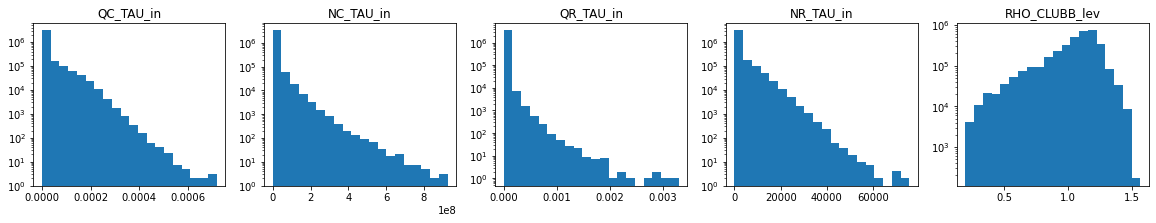

In [246]:
# Histograms of original training input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(input_train[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

In [247]:
input_test, output_test, meta_test = assemble_data_files_no_transform(test_files, input_cols, output_cols, subsample)

Finished loading 0/65 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_011100.parquet
Finished loading 10/65 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_012100.parquet
Finished loading 20/65 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_013100.parquet
Finished loading 30/65 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_014100.parquet
Finished loading 40/65 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_015100.parquet
Finished loading 50/65 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_016100.parquet
Finished loading 60/65 files... opening file ncar-aiml-data-commons/microphysics/cam_mp_data_run5_017100.parquet
Combining data
Combined Data Size (3188152, 5)


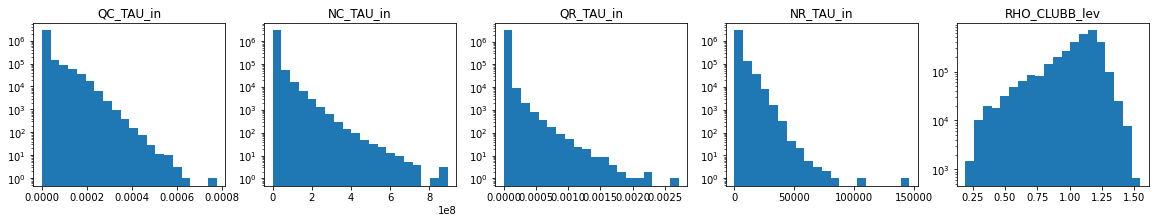

In [248]:
# Histograms of original testing input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(input_test[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

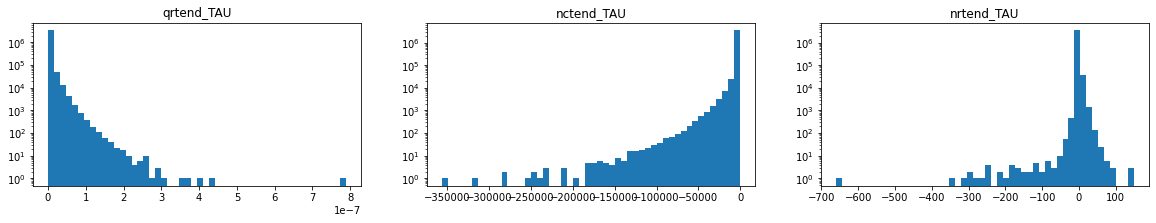

In [249]:
# Histograms of original training output data by column

fig, axes = plt.subplots(1,3, figsize=(20, 3))
for a, ax in enumerate(axes.ravel()):
    if a < len(output_cols):
        ax.set_yscale("log")
        ax.hist(output_train[output_cols[a]], bins=50)
        ax.set_title(output_cols[a])
        

Define the various transforms to be applied.

In [253]:
input_scaler = StandardScaler()

scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}

transforms = {"log10_transform": log10_transform,
              "neg_log10_transform": neg_log10_transform,
              "zero_transform": zero_transform}

inverse_transforms = {"log10_transform": inverse_log10_transform,
                      "neg_log10_transform": inverse_neg_log10_transform,
                      "zero_transform": zero_transform}

input_transforms = {"QC_TAU_in" : "log10_transform",
                    "NC_TAU_in" : "log10_transform",
                    "QR_TAU_in" : "log10_transform",
                    "NR_TAU_in" : "log10_transform"}

output_transforms = {"qrtend_TAU" : {0: ["<=", 1e-18, "zero_transform", "None"],
                                   1: [">", 1e-18, "log10_transform", "StandardScaler"]},
                     "nctend_TAU" : {0: [">=", -1e-18, "zero_transform", "None"],
                                   1: ["<", -1e-18, "neg_log10_transform", "StandardScaler"]},
                     "nrtend_TAU" : {-1: ["<", 0, "neg_log10_transform", "StandardScaler"],
                                   0: ["==", 0, "zero_transform", "None"],
                                   1: [">", 0, "log10_transform", "StandardScaler"]}}

In [254]:
scaled_input_train, labels_train, transformed_output_train, scaled_output_train, output_scalers_train = \
transform_data(input_train, output_train, meta_train, input_cols, output_cols, input_transforms, \
                                 output_transforms, input_scaler, train=True)

Transforming data


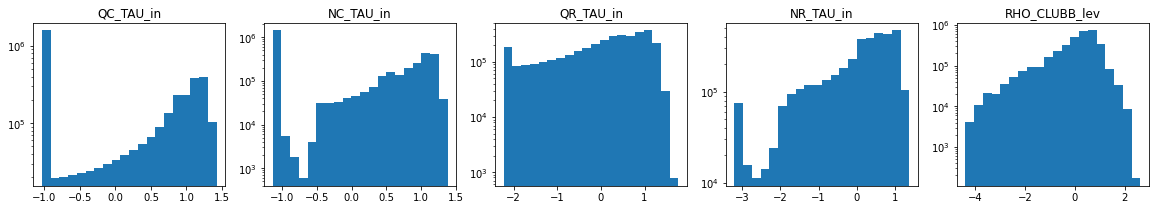

In [255]:
# Histograms of scaled and transformed input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(scaled_input_train[input_cols[a]], bins=20)
        ax.set_title(input_cols[a]) 

In [257]:
scaled_input_test, labels_test, transformed_output_test, scaled_output_test, output_scalers_test = \
    transform_data(input_test, output_test, meta_test, input_cols, output_cols, input_transforms,
                                 output_transforms, input_scaler, train=False)

Transforming data


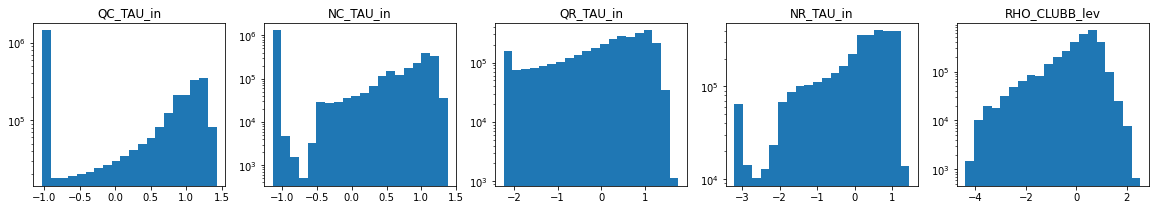

In [258]:
# Histograms of scaled and transformed input data by column

fig, axes = plt.subplots(1,5, figsize=(20, 3))
for a, ax in enumerate(axes.ravel()):
    if a < len(input_cols):
        ax.set_yscale("log")
        ax.hist(scaled_input_test[input_cols[a]], bins=20)
        ax.set_title(input_cols[a])
        

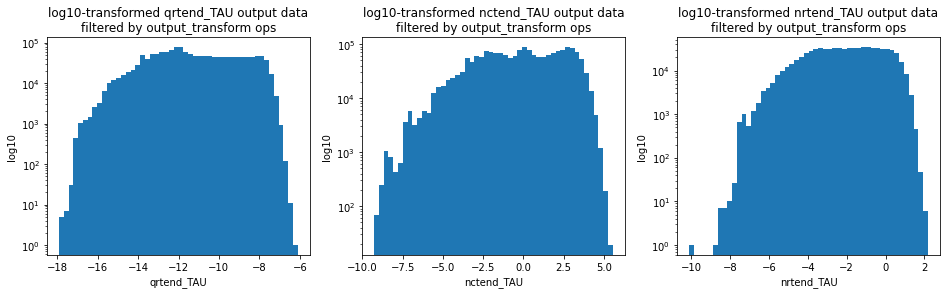

In [259]:
# output visualizations
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
for output_col, ax in zip(output_cols, (ax1, ax2, ax3)):
    original_output_train_nc = np.zeros(scaled_output_train.shape[0])
    original_output_train_nc[labels_train[output_col] == 1] = -10 ** output_scalers_train[output_col][1].inverse_transform(
        scaled_output_train.loc[labels_train[output_col] == 1, [output_col]]).ravel()
    if -1 in labels_train[output_col].keys():
        original_output_train_nc[labels_train[output_col] == -1] = -10 ** output_scalers_train[output_col][-1].inverse_transform(
            scaled_output_train.loc[labels_train[output_col] == -1, [output_col]]).ravel()
    ax.hist(np.log10(-original_output_train_nc[original_output_train_nc < 0]), bins=50)
    ax.set_xlabel(output_col)
    ax.set_ylabel('log10')
    ax.title.set_text(f"log10-transformed {output_col} output data\nfiltered by output_transform ops")
    ax.set_yscale('log')

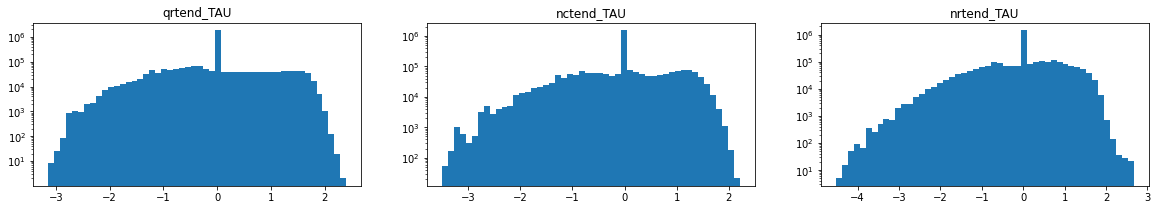

In [260]:
# Histograms of original training output data by column

fig, axes = plt.subplots(1,3, figsize=(20, 3))
for a, ax in enumerate(axes.ravel()):
    if a < len(output_cols):
        ax.set_yscale("log")
        ax.hist(scaled_output_test[output_cols[a]], bins=50)
        ax.set_title(output_cols[a])
        

In [296]:
# define model hyper parameters

#classifier_metrics = ["acc", "pss", "hss"]
#regressor_metrics = ["mse", "mae", "r2", "hellinger"]

classifier_networks = {"hidden_layers" : 4,
                       "hidden_neurons" : 30,
                       "loss" : "categorical_crossentropy",
                       "output_activation" : "softmax",
                       "activation" : "relu",
                       "epochs" : 25,
                       "batch_size" : 10240,
                       "verbose" : 1,
                       "lr" : 0.0001,
                       "l2_weight" : 1.0e-5,
                       "classifier" : 1}

regressor_networks = {"hidden_layers" : 4,
                      "hidden_neurons" : 30,
                      "loss" : "mse",
                      "output_activation" : "linear",
                      "activation" : "relu",
                      "epochs" : 25,
                      "batch_size" : 10240,
                      "verbose" : 1,
                      "lr" : 0.0001,
                      "l2_weight" : 1.0e-5,
                      "classifier" : 0}

# hyperparameter dictionaries
class_metrics = {#"accuracy": accuracy_score,
                 #"heidke": heidke_skill_score,
                 #"peirce": peirce_skill_score,
                 "zero_loss": zero_one_loss,
                 "hamming_loss": hamming_loss}
                 #"roc": roc_curve}

reg_metrics = {"rmse": root_mean_squared_error,
               "mae": mean_absolute_error,
               "r2": r2_corr,
               "hellinger": hellinger_distance}
               #"maxerr": max_error}


In [297]:
# build and fit the model

histories = {"classifiers": {}, "regressors": {}}
classifiers = dict()
regressors = dict()
reg_index = []
for output_col in output_cols:
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            reg_index.append(output_col + f"_{label:d}")
test_prediction_values = np.zeros((scaled_output_test.shape[0], len(reg_index)))
test_prediction_labels = np.zeros(scaled_output_test.shape)
#classifier_scores = pd.DataFrame(0, index=output_cols, columns=["accuracy", "heidke", "peirce"])
classifier_scores=pd.DataFrame(0, index=output_cols, columns=["zero_loss","hamming_loss"])
confusion_matrices = dict()
reg_cols = ["rmse", "mae", "r2", "hellinger"]
reg_scores = pd.DataFrame(0, index=reg_index, columns=reg_cols)
l = 0

for o, output_col in enumerate(output_cols):
    print("Train Classifer ", output_col)
    classifiers[output_col] = DenseNeuralNetwork(**classifier_networks)
    hist = classifiers[output_col].fit(scaled_input_train,
                                       labels_train[output_col],
                                       scaled_input_test,
                                       labels_test[output_col])
    histories["classifiers"][output_col] = hist
    classifiers[output_col].save_fortran_model(join(out_path,
                                                    "dnn_{0}_class_fortran.nc".format(output_col[0:2])))
    classifiers[output_col].model.save(join(out_path,"dnn_{0}_class.h5".format(output_col[0:2])))
    regressors[output_col] = dict()
    histories["regressors"][output_col] = dict()
    print("Evaluate Classifier", output_col)
    test_prediction_labels[:, o] = classifiers[output_col].predict(scaled_input_test)
    confusion_matrices[output_col] = confusion_matrix(labels_test[output_col],
                                                      test_prediction_labels  [:, o])
    for class_score in classifier_scores.columns:
        classifier_scores.loc[output_col, class_score] = class_metrics[class_score](labels_test[output_col],
                                                                                    test_prediction_labels[:, o])
    print(classifier_scores.loc[output_col])
    for label in list(output_transforms[output_col].keys()):
        if label != 0:
            print("Train Regressor ", output_col, label)
            regressors[output_col][label] = DenseNeuralNetwork(**regressor_networks)
            hist = regressors[output_col][label].fit(scaled_input_train.loc[labels_train[output_col] == label],
                                                     scaled_output_train.loc[labels_train[output_col] == label, output_col],
                                                     scaled_input_test.loc[labels_test[output_col] == label],
                                                     scaled_output_test.loc[labels_test[output_col] == label, output_col])
            histories["regressors"][output_col][label] = hist

            if label > 0:
                out_label = "pos"
            else:
                out_label = "neg"
            regressors[output_col][label].save_fortran_model(join(out_path,
                                                                  "dnn_{0}_{1}_fortran.nc".format(output_col[0:2],
                                                                                                  out_label)))
            regressors[output_col][label].model.save(join(out_path,
                                                          "dnn_{0}_{1}.h5".format(output_col[0:2], out_label)))
            print("Test Regressor", output_col, label)
            test_prediction_values[:, l] = output_scalers_test[output_col][label].inverse_transform(regressors[output_col][label].predict(scaled_input_test))
            reg_label = output_col + f"_{label:d}"
            for reg_col in reg_cols:
                reg_scores.loc[reg_label,
                               reg_col] = reg_metrics[reg_col](transformed_output_test.loc[labels_test[output_col] == label,
                                                                                        output_col],
                                                                test_prediction_values[labels_test[output_col] == label, l])
            print(reg_scores.loc[reg_label])
            l += 1
print("Saving data")
#classifier_scores.to_csv(join(out_path, "dnn_classifier_scores.csv"), index_label="Output")
#reg_scores.to_csv(join(out_path, "dnn_regressor_scores.csv"), index_label="Output")
#test_pred_values_df = pd.DataFrame(test_prediction_values, columns=reg_index)
#test_pred_labels_df = pd.DataFrame(test_prediction_labels, columns=output_cols)
#test_pred_values_df.to_csv(join(out_path, "test_prediction_values.csv"), index_label="index")
#test_pred_labels_df.to_csv(join(out_path, "test_prediction_labels.csv"), index_label="index")
#labels_test.to_csv(join(out_path, "test_cam_labels.csv"), index_label="index")
#transformed_out_test.to_csv(join(out_path, "test_cam_values.csv"), index_label="index")


Train Classifer  qrtend_TAU
Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 30)                180       
_________________________________________________________________
dense_01 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_02 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_03 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_04 (Dense)             (None, 2)                 62        
Total params: 3,032
Trainable params: 3,032
Non-trainable params: 0
____________________________

In [298]:
reg_scores

,rmse,mae,r2,hellinger
qrtend_TAU_1,0.374220,0.222358,0.968246,0.001376
nctend_TAU_1,0.299403,0.165699,0.986733,0.001735
nrtend_TAU_-1,0.333173,0.190485,0.978315,0.003245
nrtend_TAU_1,0.545741,0.393627,0.910872,0.002939


In [281]:
reg_scores

,rmse,mae,r2,hellinger
qrtend_TAU_1,0.309242,0.185215,0.979048,0.000844
nctend_TAU_1,0.277845,0.151386,0.988756,0.001102
nrtend_TAU_-1,0.291121,0.159634,0.983560,0.001734
nrtend_TAU_1,0.433601,0.298312,0.947136,0.001961


In [282]:
classifier_scores

,zero_loss,hamming_loss
qrtend_TAU,0.031126,0.031126
nctend_TAU,0.010096,0.010096
nrtend_TAU,0.034231,0.034231


In [332]:
#Dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [333]:
# define a model

# number of inputs
n_inputs = 5
n_outputs = 3

model = Sequential() # this means we will define layer by layer
model.add(Dense(16, input_dim=n_inputs, activation='relu')) # 1st hidden layer
model.add(Dense(12, activation='relu')) # 2nd hidden layer
model.add(Dense(n_outputs, activation='softmax'))

# specify the loss function and the optimizer
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])



# 2nd model with more layers and different learning rate
# layer configuration taken from baseline model

model2 = Sequential() # this means we will define layer by layer
model2.add(Dense(16, input_dim=n_inputs, activation='relu')) # 1st hidden layer
model2.add(Dense(12, activation='relu')) # 2nd hidden layer
model2.add(Dense(30, activation='relu')) # 3rd hidden layer
model2.add(Dense(30, activation='relu')) # 4th hidden layer
model2.add(Dense(n_outputs, activation='softmax'))

# change learning rate
opt = Adam(learning_rate=0.01)
model2.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

In [334]:
scaled_input_train

,QC_TAU_in,NC_TAU_in,QR_TAU_in,NR_TAU_in,RHO_CLUBB_lev
0,-1.033680,-1.136830,-1.771410,-1.486039,-1.333986
1,-1.033680,-1.136830,-1.771603,-1.486241,-1.333987
2,-1.033680,-1.136830,-1.771689,-1.486331,-1.333987
3,-1.033680,-1.136830,-1.771698,-1.486341,-1.333987
4,-1.033680,-1.136830,-1.771698,-1.486341,-1.333987
...,...,...,...,...,...
3562910,0.512482,-0.370040,-2.233659,-3.206917,2.151198
3562911,1.144300,1.164831,-1.098519,-0.763692,2.117233
3562912,1.127750,1.167978,-2.233659,-3.206917,2.112975
3562913,1.067535,1.130409,-2.233659,-3.206917,2.164735


In [335]:
# train model
history = model.fit(scaled_input_train, labels_train,validation_data = (scaled_input_test,labels_test), epochs=20, batch_size=1024)

Epoch 1/20
3480/3480 [==============================] - 15s 4ms/step - loss: 0.3245 - accuracy: 0.4079 - val_loss: 0.3198 - val_accuracy: 0.4295
Epoch 2/20
3480/3480 [==============================] - 15s 4ms/step - loss: 0.3155 - accuracy: 0.4319 - val_loss: 0.3178 - val_accuracy: 0.4981
Epoch 3/20
3480/3480 [==============================] - 15s 4ms/step - loss: 0.3142 - accuracy: 0.4123 - val_loss: 0.3170 - val_accuracy: 0.4725
Epoch 4/20
3480/3480 [==============================] - 15s 4ms/step - loss: 0.3137 - accuracy: 0.4241 - val_loss: 0.3168 - val_accuracy: 0.4440
Epoch 5/20
3480/3480 [==============================] - 15s 4ms/step - loss: 0.3134 - accuracy: 0.4420 - val_loss: 0.3164 - val_accuracy: 0.3730
Epoch 6/20
3480/3480 [==============================] - 15s 4ms/step - loss: 0.3132 - accuracy: 0.4507 - val_loss: 0.3163 - val_accuracy: 0.2311
Epoch 7/20
3480/3480 [==============================] - 15s 4ms/step - loss: 0.3131 - accuracy: 0.4494 - val_loss: 0.3163 - val_ac

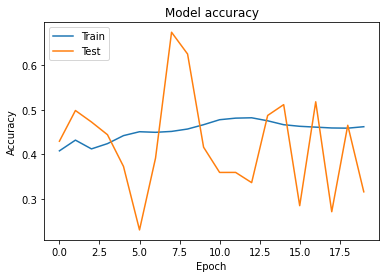

In [336]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



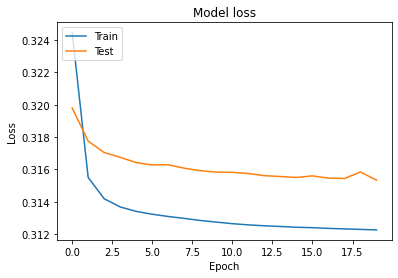

In [337]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
output_col="nctend_TAU"

In [ ]:
clf.fit(scaled_input_train,labels_train[output_col])

In [ ]:
clf.score(scaled_input_test,labels_test[output_col])

In [ ]:
clfv2 = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=500, min_samples_leaf=5)

In [ ]:
clfv2.fit(scaled_input_train,labels_train[output_col])

In [ ]:
clfv2.score(scaled_input_test,labels_test[output_col])

In [ ]:
clfv3 = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=500, min_samples_leaf=50)

In [ ]:
clfv3.fit(scaled_input_train,labels_train[output_col])

In [ ]:
clfv3.score(scaled_input_test,labels_test[output_col])

In [ ]:
output_col="qrtend_TAU"

In [ ]:
clfv3.fit(scaled_input_train,labels_train[output_col])

In [ ]:
clfv3.score(scaled_input_test,labels_test[output_col])

In [ ]:
# load and view a single file

fs = s3fs.S3FileSystem(anon=True)
filenames = fs.ls("s3://ncar-aiml-data-commons/microphysics")
fobj = fs.open(filenames[0])
single_file = pd.read_parquet(fobj).set_index('Index')
single_file


In [ ]:
import xarray as xr

In [ ]:
xrdf = single_file.to_xarray()

In [ ]:
xrdf

In [ ]:
xrdf.expand_dims({'latitude':xrdf.lat,'longitude':xrdf.lon})

In [ ]:
xrdf.sel('lat'=slice(-5,5),longitude=slice(170,240))